<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf


In [3]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/Git/Autoencoder_Embedding_Expert_Caracteristion_'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [4]:
#import class and methods from src
from tensorflow.keras import backend as K
from CVAE.callbacks import *
#from CVAE.cvae import compile_cvae, run_cvae
from conso.load_shape_data import *

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error


In [5]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
%load_ext autoreload
%autoreload



Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2017. 

In [6]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

#Visualize data frame head
x_conso.tail(5)

,ds,consumption_France,temperature_France,is_holiday_day
87825,2017-12-31 21:30:00,56505.0,9.306475,0.0
87826,2017-12-31 22:00:00,56000.0,9.097250,0.0
87827,2017-12-31 22:30:00,56995.0,9.048775,0.0
87828,2017-12-31 23:00:00,60395.0,9.000300,0.0
87829,2017-12-31 23:30:00,60230.0,9.000300,0.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, il est ici normalisé sur l'ensemble des mesures.

In [7]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [8]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)


Le dictionnaire dataset contient toutes les informations nécessaires à l'entrainement des modèles :
- dataset['train']['x'] contient la liste des entrées de l'encodeur:
-- [0] les profils de consommations
-- [1] les conditions passées en entrée de l'encodeur et du décodeur pour rendre la représentation latente plus indépendante de ces variables
- dataset['train']['y'] contient une copie des profils des consommation (pointeur pour le calcul des pertes de reconstruction dans l'apprentissage des modèles)
- dataset['train']['ds'] contient les dates des exemples

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [9]:
#importation des données calendaires
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0
calendar_info['year'] = calendar_info.ds.dt.year


In [10]:
calendar_info

,ds,month,weekday,is_weekday,is_holiday_day,year
0,2012-12-28,12,4,1,0.0,2012
1,2012-12-29,12,5,0,0.0,2012
2,2012-12-30,12,6,0,0.0,2012
3,2012-12-31,12,0,1,0.0,2012
4,2013-01-01,1,1,1,1.0,2013
...,...,...,...,...,...,...
1825,2017-12-27,12,2,1,0.0,2017
1826,2017-12-28,12,3,1,0.0,2017
1827,2017-12-29,12,4,1,0.0,2017
1828,2017-12-30,12,5,0,0.0,2017


In [11]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info.ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info.ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [12]:
meteo_records.describe()

,snow,floods,storm,hurricane,heavy_rains,cold,hot
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000
mean,0.092350,0.077049,0.087432,0.068852,0.087432,0.074863,0.157377
std,0.289598,0.266742,0.282544,0.253272,0.282544,0.263243,0.364255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [14]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [15]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor'
}

In [16]:
meteo_records

,snow,floods,storm,hurricane,heavy_rains,cold,hot
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1825,0,0,0,0,0,0,0
1826,0,0,0,0,0,0,0
1827,0,0,0,0,0,0,0
1828,0,0,0,0,0,0,0


# Tools to evaluate the representations

In [17]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(2, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(2, 3, 2)
    plt.bar(np.arange(z_dim)+1,np.log(6)*model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(2, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();
    
    plt.subplot(2, 3, 5)
    plt.bar(np.arange(z_dim)+1,1-model_eval['modularity'])
    plt.xlabel('latent variables')
    plt.title('Modularity score : %.2f'%np.mean(1-model_eval['modularity']));

In [18]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [19]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [20]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle
mean_sc, var_sc = stats.describe(x_conso.consumption_France)[2:4]
std_sc = np.sqrt(var_sc)
def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(x*std_sc+ mean_sc, label = 'truth')
    plt.plot(x_hat*std_sc+ mean_sc, '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

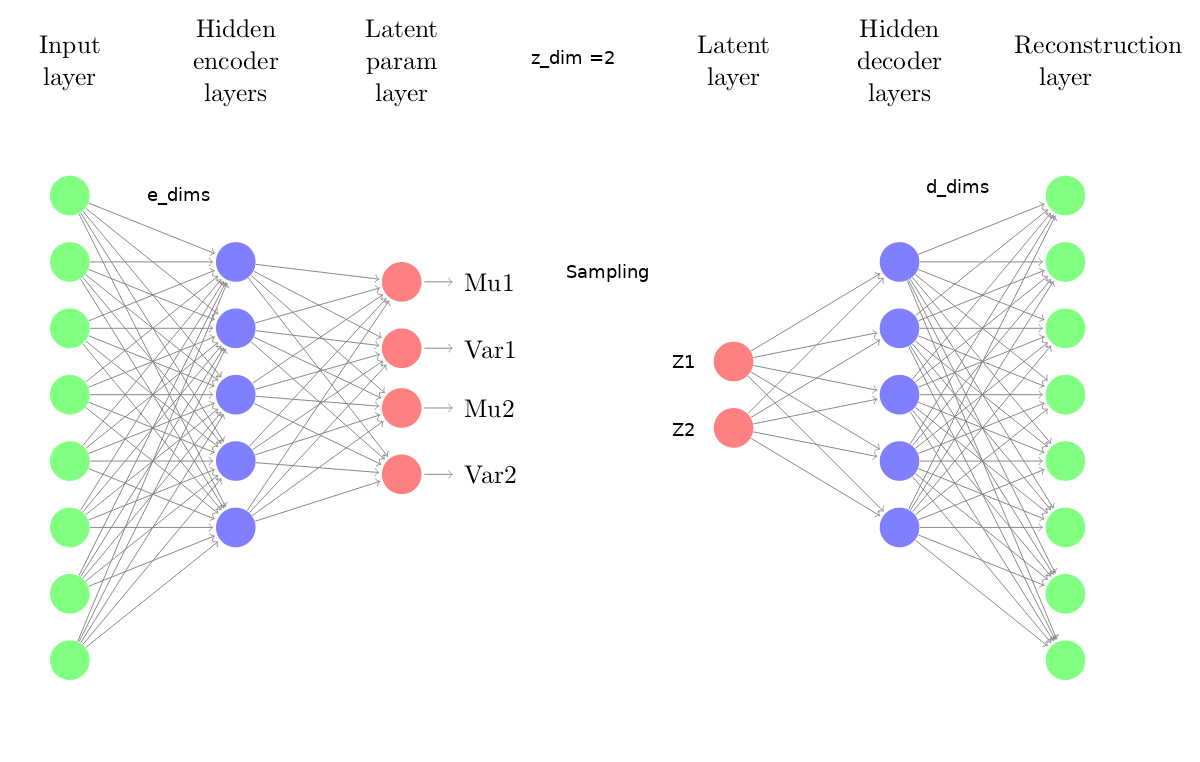

In [21]:
Image(path_main_folder+'/images/VAE.png', width=1000, height=150)

In [22]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,96,35,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 

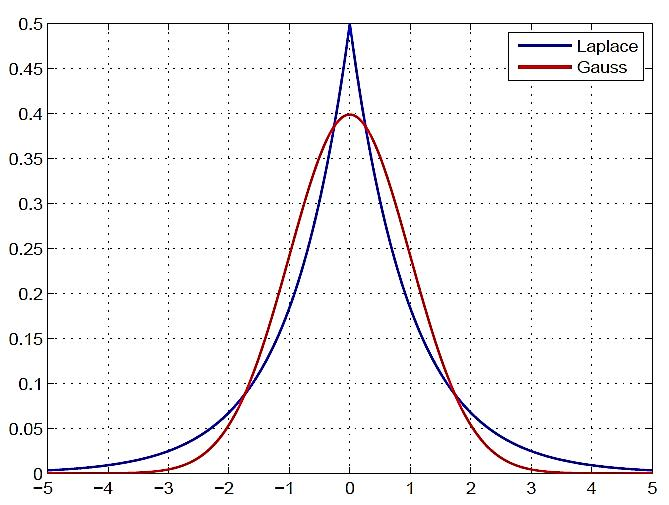

In [23]:
Image(path_main_folder+'/images/lois_laplace_normale.jpg', width=500)


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [25]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

In [26]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
%load_ext autoreload
%autoreload

importlib.reload(Visualisation.buildProjector)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'Visualisation.buildProjector' from '/home/goubetcle/Documents/Git/Autoencoder_Embedding_Expert_Caracteristion_/src/Visualisation/buildProjector.py'>

all_info = calendar_info.join(meteo_records)
tensorProj = True
if tensorProj:
    tensorboardProjection(name_model,x,x_hat, x_encoded, x_conso, all_info, log_dir_projector, includeConsumptionProfileImages=True)

In [27]:
to_cond = ["temperature", "month", "weekday"]
dataset_emb, cond_to_emb = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=to_cond, embedding=True)

temperature (1830, 48)
month (1830, 12)
weekday (1830, 1)
4


In [28]:
#root git folder 
name_model="vae_test"
path_second_folder = "/home/goubetcle/Documents/Git/VAE/"
save_path = "/home/goubetcle/Documents/VAE/"
log_dir_model=save_path+"/logs/Usecase/"
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [29]:
import models, loss_class, params_class,AE_blocks
from models import *
importlib.reload(models)
from loss_class import *
importlib.reload(loss_class)
from params_class import *
importlib.reload(params_class)
import AE_blocks
importlib.reload(AE_blocks)


<module 'AE_blocks' from '/home/goubetcle/Documents/Git/VAE/AE_blocks.py'>

In [30]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [31]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [48, 48, 24, 12]
decoder_type  :=  InceptionBlock_model
Default parameters for training are a L1 loss with Adam optimizer with a learning rate of 0.0003


In [33]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = cond_to_emb
vae_params.model_params.with_embedding = False
vae_params.model_params.emb_dims = [[36,22,10],[12,4],[],6]
vae_params.model_params.nb_encoder_ensemble = 1
vae_params.model_params.encoder_type="NNBlockConv1D_model"

In [35]:

def loss_1(y_true, y_pred):
    return K.sum(y_true)

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{} }}

loss_weights = {"recon_loss" : 10,
                "kl_loss" : 0.3,
                "info_loss" : 42}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1]

In [36]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/home/goubetcle/Documents/VAE//logs/Usecase/vae_test',
 'model_params': <params_class.ModelParams at 0x7ffac5d9c8d0>,
 'training_params': <params_class.TrainingParams at 0x7ffac5d9c910>}

In [45]:
new_cae.build_model(vae_params)

Model: "cae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
cond_inputs_2 (InputLayer)      [(None, 1)]          0                                            
________________________________________________________________________________________________

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


## START TRAINING ##
Train on 1647 samples, validate on 183 samples
Epoch 1/800
1647/1647 [==============================] - 1s 520us/sample - loss: 409.4359 - val_loss: 216.4607
Epoch 2/800
1647/1647 [==============================] - 0s 231us/sample - loss: 142.1992 - val_loss: 123.3317
Epoch 3/800
1647/1647 [==============================] - 0s 229us/sample - loss: 89.1723 - val_loss: 81.8158
Epoch 4/800
1647/1647 [==============================] - 0s 232us/sample - loss: 62.6069 - val_loss: 58.8581
Epoch 5/800
1647/1647 [==============================] - 0s 222us/sample - loss: 47.6562 - val_loss: 46.1919
Epoch 6/800
1647/1647 [==============================] - 0s 229us/sample - loss: 39.4085 - val_loss: 40.4509
Epoch 7/800
1647/1647 [==============================] - 0s 226us/sample - loss: 34.0748 - val_loss: 33.8400
Epoch 8/800
1647/1647 [==============================] - 0s 230us/sample - loss: 30.1418 - val_loss: 29.9598
Epoch 9/800
1647/1647 [==============================] -

Epoch 76/800
1647/1647 [==============================] - 0s 222us/sample - loss: 6.2848 - val_loss: 6.3428
Epoch 77/800
1647/1647 [==============================] - 0s 220us/sample - loss: 6.2646 - val_loss: 6.4162
Epoch 78/800
1647/1647 [==============================] - 0s 222us/sample - loss: 6.2028 - val_loss: 6.2458
Epoch 79/800
1647/1647 [==============================] - 0s 222us/sample - loss: 6.1890 - val_loss: 6.2496
Epoch 80/800
1647/1647 [==============================] - 0s 222us/sample - loss: 6.1310 - val_loss: 6.1427
Epoch 81/800
1647/1647 [==============================] - 0s 221us/sample - loss: 6.1114 - val_loss: 6.1173
Epoch 82/800
1647/1647 [==============================] - 0s 219us/sample - loss: 6.0643 - val_loss: 6.1974
Epoch 83/800
1647/1647 [==============================] - 0s 221us/sample - loss: 5.9870 - val_loss: 5.9123
Epoch 84/800
1647/1647 [==============================] - 0s 220us/sample - loss: 5.9576 - val_loss: 6.0135
Epoch 85/800
1647/1647 [====

1647/1647 [==============================] - 0s 223us/sample - loss: 4.1244 - val_loss: 4.4549
Epoch 152/800
1647/1647 [==============================] - 0s 219us/sample - loss: 4.1753 - val_loss: 4.2324
Epoch 153/800
1647/1647 [==============================] - 0s 222us/sample - loss: 4.1707 - val_loss: 4.2602
Epoch 154/800
1647/1647 [==============================] - 0s 216us/sample - loss: 4.1534 - val_loss: 4.3056
Epoch 155/800
1647/1647 [==============================] - 0s 222us/sample - loss: 4.1348 - val_loss: 4.2420
Epoch 156/800
1647/1647 [==============================] - 0s 222us/sample - loss: 4.1527 - val_loss: 4.2555
Epoch 157/800
1647/1647 [==============================] - 0s 220us/sample - loss: 4.1108 - val_loss: 4.0739
Epoch 158/800
1647/1647 [==============================] - 0s 218us/sample - loss: 4.1298 - val_loss: 4.2469
Epoch 159/800
1647/1647 [==============================] - 0s 220us/sample - loss: 4.0750 - val_loss: 4.0685
Epoch 160/800
1647/1647 [========

1647/1647 [==============================] - 0s 221us/sample - loss: 3.6410 - val_loss: 3.6766
Epoch 227/800
1647/1647 [==============================] - 0s 224us/sample - loss: 3.6255 - val_loss: 3.6901
Epoch 228/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.6304 - val_loss: 3.7224
Epoch 229/800
1647/1647 [==============================] - 0s 219us/sample - loss: 3.6115 - val_loss: 3.6528
Epoch 230/800
1647/1647 [==============================] - 0s 219us/sample - loss: 3.6268 - val_loss: 3.6932
Epoch 231/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.6273 - val_loss: 3.7015
Epoch 232/800
1647/1647 [==============================] - 0s 216us/sample - loss: 3.6354 - val_loss: 3.7381
Epoch 233/800
1647/1647 [==============================] - 0s 219us/sample - loss: 3.5951 - val_loss: 3.6916
Epoch 234/800
1647/1647 [==============================] - 0s 218us/sample - loss: 3.6256 - val_loss: 3.6757
Epoch 235/800
1647/1647 [========

1647/1647 [==============================] - 0s 222us/sample - loss: 3.3883 - val_loss: 3.5345
Epoch 302/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.3702 - val_loss: 3.4671
Epoch 303/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.3347 - val_loss: 3.3930
Epoch 304/800
1647/1647 [==============================] - 0s 219us/sample - loss: 3.3935 - val_loss: 3.4800
Epoch 305/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.3657 - val_loss: 3.4354
Epoch 306/800
1647/1647 [==============================] - 0s 218us/sample - loss: 3.3522 - val_loss: 3.4550
Epoch 307/800
1647/1647 [==============================] - 0s 225us/sample - loss: 3.3311 - val_loss: 3.4033
Epoch 308/800
1647/1647 [==============================] - 0s 219us/sample - loss: 3.3458 - val_loss: 3.5134
Epoch 309/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.3580 - val_loss: 3.4643
Epoch 310/800
1647/1647 [========

1647/1647 [==============================] - 0s 220us/sample - loss: 3.2376 - val_loss: 3.3821
Epoch 377/800
1647/1647 [==============================] - 0s 217us/sample - loss: 3.2530 - val_loss: 3.2843
Epoch 378/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.2687 - val_loss: 3.2989
Epoch 379/800
1647/1647 [==============================] - 0s 217us/sample - loss: 3.2308 - val_loss: 3.3548
Epoch 380/800
1647/1647 [==============================] - 0s 216us/sample - loss: 3.2393 - val_loss: 3.3660
Epoch 381/800
1647/1647 [==============================] - 0s 224us/sample - loss: 3.2243 - val_loss: 3.2307
Epoch 382/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.1668 - val_loss: 3.2123
Epoch 383/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.1817 - val_loss: 3.2600
Epoch 384/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.1825 - val_loss: 3.2533
Epoch 385/800
1647/1647 [========

1647/1647 [==============================] - 0s 221us/sample - loss: 3.1431 - val_loss: 3.2105
Epoch 452/800
1647/1647 [==============================] - 0s 218us/sample - loss: 3.0814 - val_loss: 3.1532
Epoch 453/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.1138 - val_loss: 3.1490
Epoch 454/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.1291 - val_loss: 3.2741
Epoch 455/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.1251 - val_loss: 3.2533
Epoch 456/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.0974 - val_loss: 3.0755
Epoch 457/800
1647/1647 [==============================] - 0s 217us/sample - loss: 3.1319 - val_loss: 3.2382
Epoch 458/800
1647/1647 [==============================] - 0s 227us/sample - loss: 3.1460 - val_loss: 3.2503
Epoch 459/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.1439 - val_loss: 3.2682
Epoch 460/800
1647/1647 [========

1647/1647 [==============================] - 0s 219us/sample - loss: 3.0353 - val_loss: 3.1910
Epoch 527/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.0930 - val_loss: 3.1417
Epoch 528/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.0372 - val_loss: 3.1113
Epoch 529/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.0991 - val_loss: 3.1479
Epoch 530/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.0528 - val_loss: 3.1100
Epoch 531/800
1647/1647 [==============================] - 0s 219us/sample - loss: 3.0477 - val_loss: 3.1551
Epoch 532/800
1647/1647 [==============================] - 0s 221us/sample - loss: 3.0835 - val_loss: 3.1019
Epoch 533/800
1647/1647 [==============================] - 0s 219us/sample - loss: 3.0671 - val_loss: 3.1079
Epoch 534/800
1647/1647 [==============================] - 0s 224us/sample - loss: 3.0294 - val_loss: 3.1946
Epoch 535/800
1647/1647 [========

1647/1647 [==============================] - 0s 227us/sample - loss: 2.9999 - val_loss: 3.0878
Epoch 602/800
1647/1647 [==============================] - 0s 224us/sample - loss: 3.0322 - val_loss: 3.0845
Epoch 603/800
1647/1647 [==============================] - 0s 218us/sample - loss: 3.0058 - val_loss: 3.0758
Epoch 604/800
1647/1647 [==============================] - 0s 218us/sample - loss: 2.9957 - val_loss: 3.1748
Epoch 605/800
1647/1647 [==============================] - 0s 220us/sample - loss: 3.0195 - val_loss: 3.0628
Epoch 606/800
1647/1647 [==============================] - 0s 247us/sample - loss: 3.0203 - val_loss: 3.0137
Epoch 607/800
1647/1647 [==============================] - 0s 246us/sample - loss: 3.0099 - val_loss: 3.0247
Epoch 608/800
1647/1647 [==============================] - 0s 242us/sample - loss: 3.0009 - val_loss: 3.0275
Epoch 609/800
1647/1647 [==============================] - 0s 238us/sample - loss: 2.9975 - val_loss: 3.0399
Epoch 610/800
1647/1647 [========

1647/1647 [==============================] - 0s 220us/sample - loss: 2.9754 - val_loss: 3.0132
Epoch 677/800
1647/1647 [==============================] - 0s 220us/sample - loss: 2.9583 - val_loss: 2.9668
Epoch 678/800
1647/1647 [==============================] - 0s 220us/sample - loss: 2.9764 - val_loss: 2.9854
Epoch 679/800
1647/1647 [==============================] - 0s 221us/sample - loss: 2.9287 - val_loss: 3.0433
Epoch 680/800
1647/1647 [==============================] - 0s 217us/sample - loss: 2.9537 - val_loss: 3.0617
Epoch 681/800
1647/1647 [==============================] - 0s 219us/sample - loss: 2.9641 - val_loss: 3.0105
Epoch 682/800
1647/1647 [==============================] - 0s 223us/sample - loss: 2.9868 - val_loss: 3.0894
Epoch 683/800
1647/1647 [==============================] - 0s 217us/sample - loss: 2.9704 - val_loss: 3.0052
Epoch 684/800
1647/1647 [==============================] - 0s 220us/sample - loss: 2.9639 - val_loss: 3.0378
Epoch 685/800
1647/1647 [========

1647/1647 [==============================] - 0s 217us/sample - loss: 2.9074 - val_loss: 2.9167
Epoch 752/800
1647/1647 [==============================] - 0s 223us/sample - loss: 2.9282 - val_loss: 2.8845
Epoch 753/800
1647/1647 [==============================] - 0s 217us/sample - loss: 2.9116 - val_loss: 3.0964
Epoch 754/800
1647/1647 [==============================] - 0s 218us/sample - loss: 2.8809 - val_loss: 2.9564
Epoch 755/800
1647/1647 [==============================] - 0s 219us/sample - loss: 2.9093 - val_loss: 3.0155
Epoch 756/800
1647/1647 [==============================] - 0s 223us/sample - loss: 2.9119 - val_loss: 2.9294
Epoch 757/800
1647/1647 [==============================] - 0s 219us/sample - loss: 2.9069 - val_loss: 3.0026
Epoch 758/800
1647/1647 [==============================] - 0s 221us/sample - loss: 2.9118 - val_loss: 3.0057
Epoch 759/800
1647/1647 [==============================] - 0s 217us/sample - loss: 2.8991 - val_loss: 3.0883
Epoch 760/800
1647/1647 [========

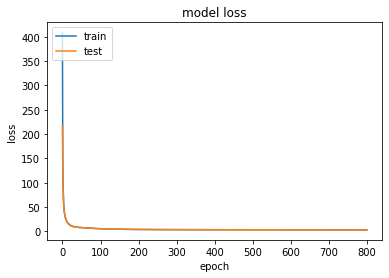

## MODEL SAVED ##


In [47]:
new_cae.train(dataset_emb['train']['x'], dataset['train']['y'], epochs= epochs, verbose=1,
              batch_size=batch_size, callbacks=[earl_stop])

In [38]:
x_encoded = new_cae.encoder.predict(dataset_emb['train']['x'])[0]

Mutual Information Gap : 0.04


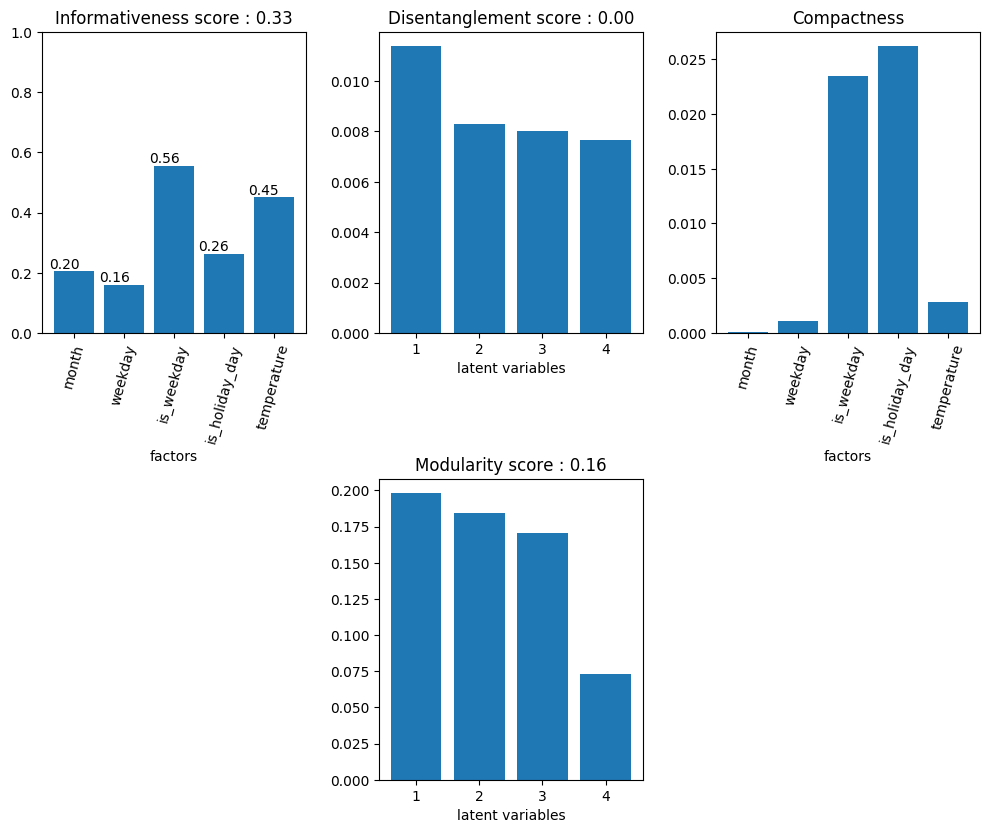

In [49]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, z_dim, factorDesc)

In [50]:
x_hat = new_cae.model.predict(dataset_emb['train']['x'])[0]

np.mean(np.abs(x_hat - dataset_emb['train']['x'][0]))

0.8749683492645455

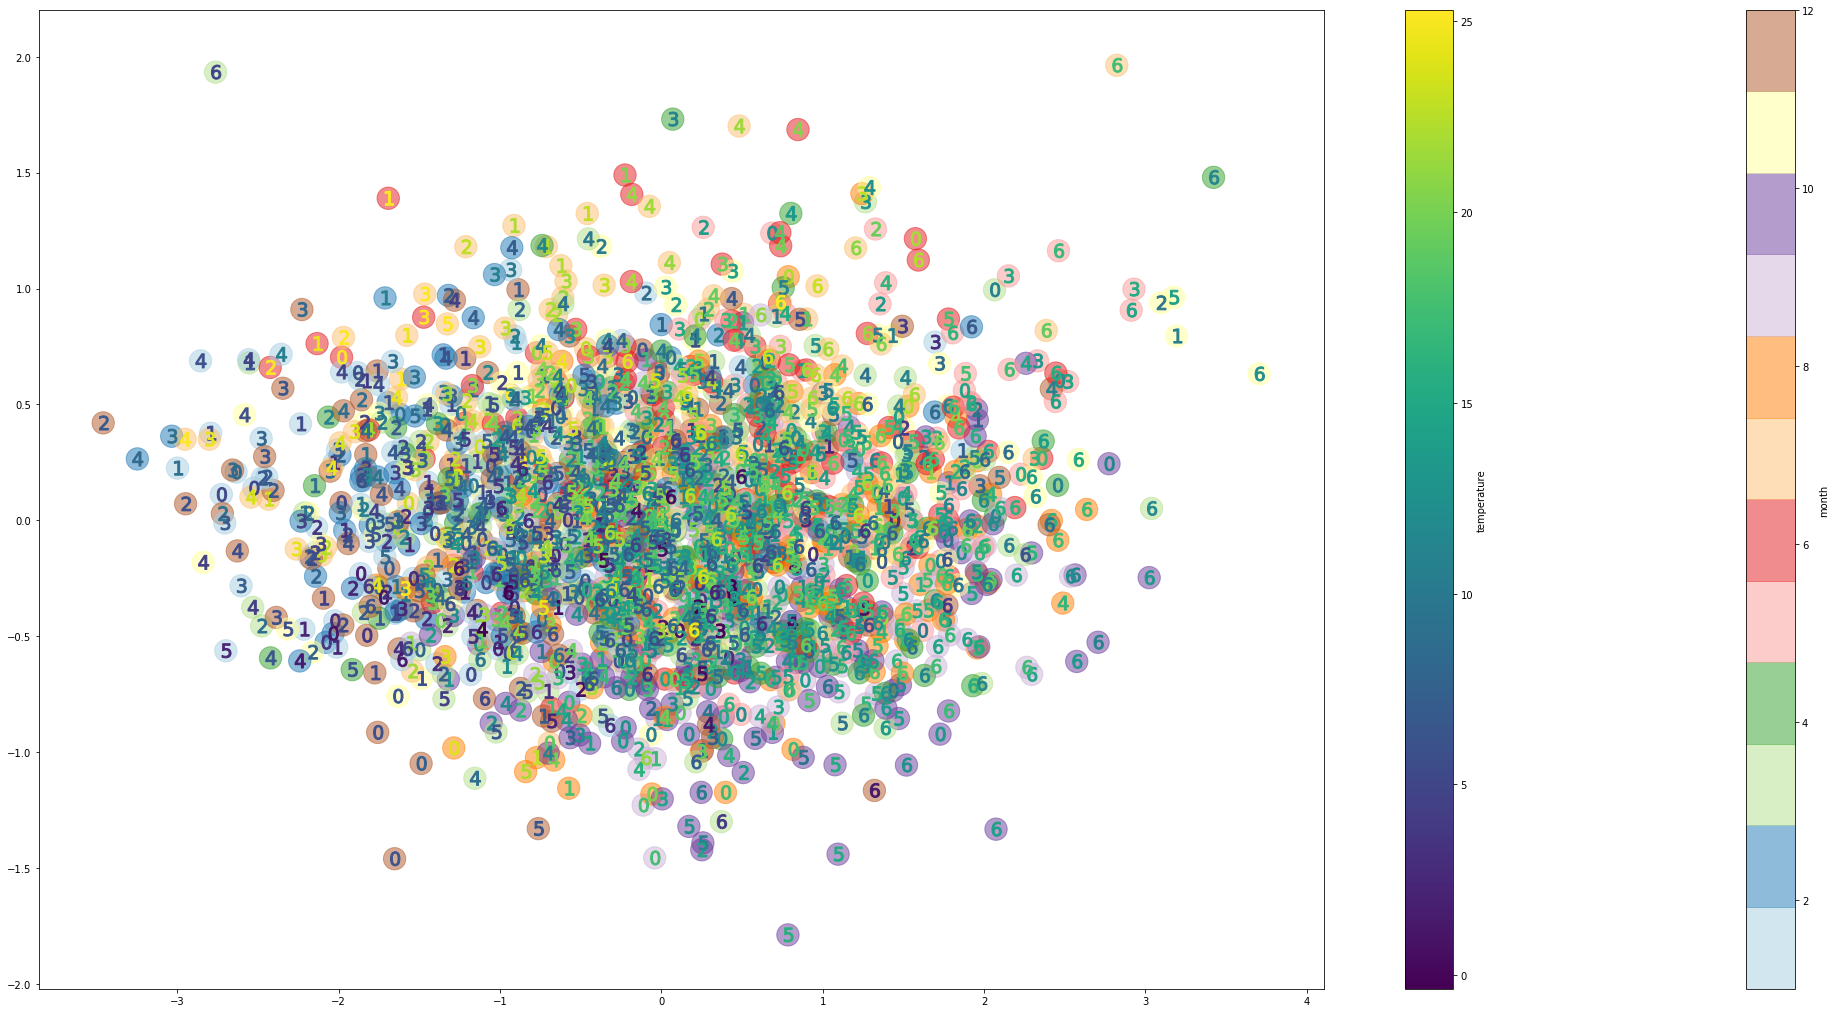

In [51]:
prez_2D(x_encoded)

In [37]:
new_cae.load_model()

Default parameters for training are a L1 loss with Adam optimizer with a learning rate of 0.0003
Model: "cae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_inputs (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_0 (InputLayer)      [(None, 48)]         0                                            
__________________________________________________________________________________________________
cond_inputs_1 (InputLayer)      [(None, 12)]         0                                            
__________________________________________________________________________________________________
cond_inputs_2 (InputLayer)      [(None, 1)]          0                                            

In [39]:
cond_emb = new_cae.to_embedding(dataset_emb['train']['x'][1:])

AttributeError: 'CVAE' object has no attribute 'to_embedding'

Mutual Information Gap : 0.22


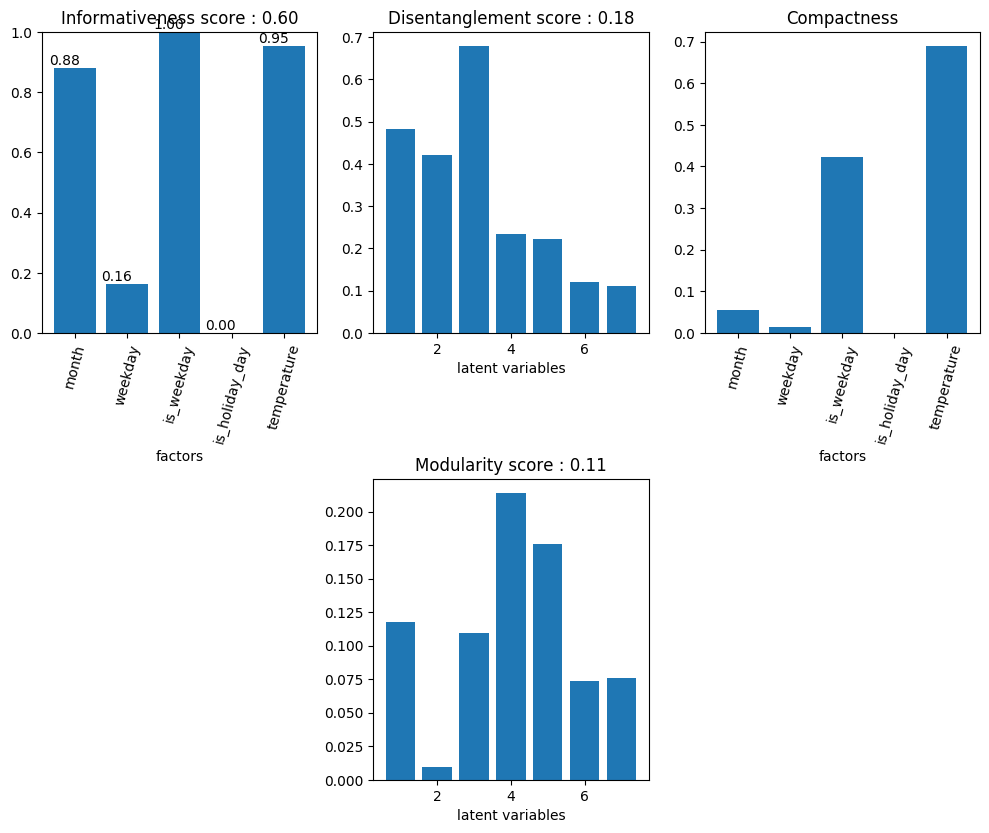

In [432]:
model_eval, importanceMatrix =evaluateLatentCode(cond_emb, factorMatrix, factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_metrics(model_eval, 7, factorDesc)